In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pydaptivefiltering as pdf

[DualSign] Completed in 9.288 ms


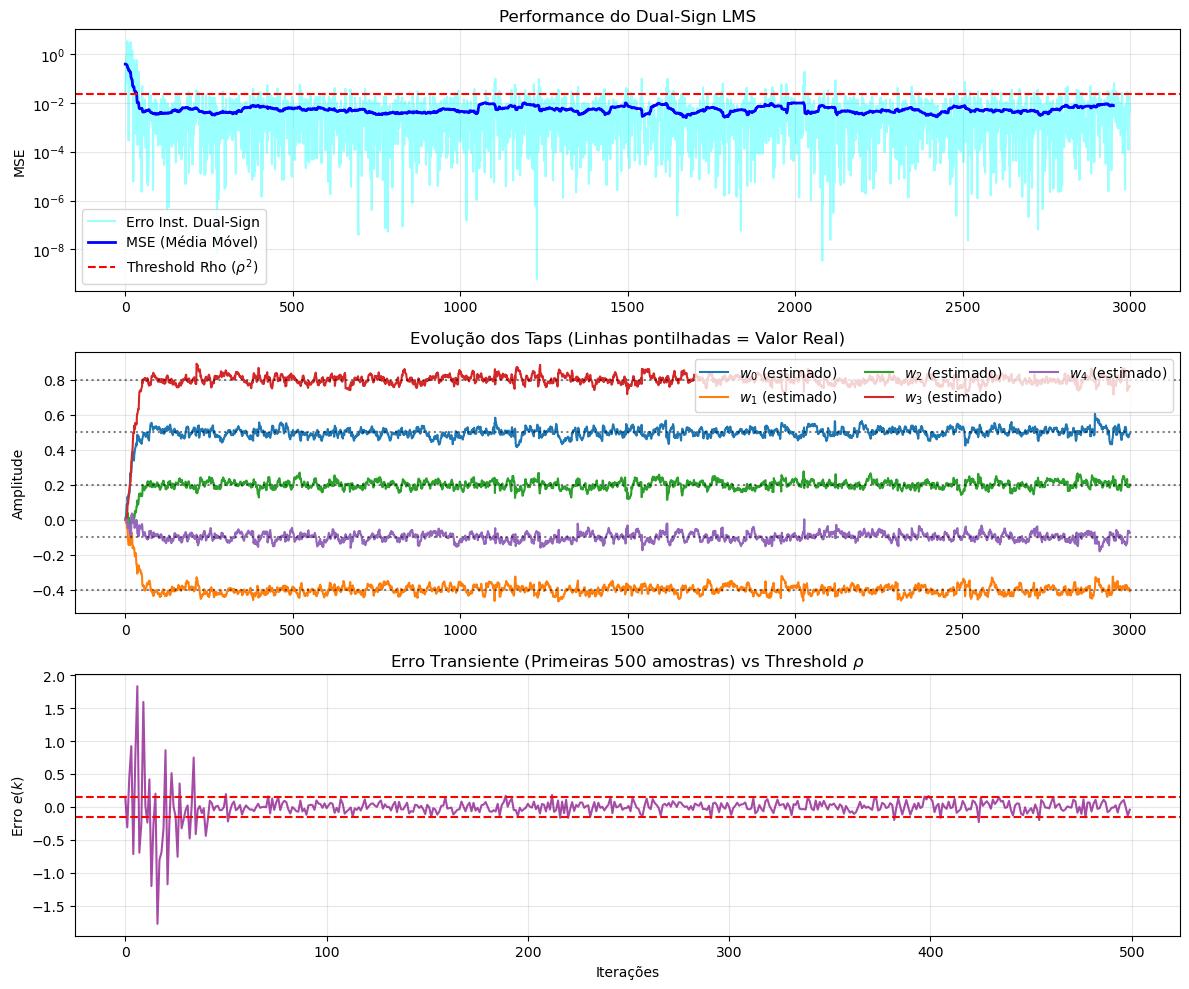

Coeficientes Finais: [ 0.4907 -0.4086  0.2005  0.7623 -0.0754]
Coeficientes Reais:  [ 0.5 -0.4  0.2  0.8 -0.1]


In [2]:
# --- 1. GERAÇÃO DE DADOS (Cenário de Identificação de Sistema) ---
np.random.seed(42)
n_samples = 3000
filter_order = 4  # 5 taps

# Entrada: Ruído branco (o Dual-Sign LMS lida melhor com entradas simples)
x = np.random.randn(n_samples)

# Sistema Desconhecido (Planta)
w_true = np.array([0.5, -0.4, 0.2, 0.8, -0.1])
d_clean = np.convolve(x, w_true, mode='full')[:n_samples]
# Adicionando ruído de medição
d = d_clean + 0.05 * np.random.randn(n_samples)

# --- 2. INSTANCIAÇÃO E EXECUÇÃO ---
# rho: Se o erro for > 0.15, usa o ganho amplificado gamma
# gamma: Multiplicador do passo (ex: 4x mais rápido se o erro for grande)
# step: Mu base
filt_ds = pdf.DualSign(
    filter_order=filter_order,
    rho=0.15,
    gamma=3,
    step=0.005
)

result = filt_ds.optimize(x, d, verbose=True)

# --- 3. VISUALIZAÇÃO ---
plt.figure(figsize=(12, 10))

# Subplot 1: Erro Quadrático Instantâneo
plt.subplot(3, 1, 1)
plt.semilogy(result.mse(), label='Erro Inst. Dual-Sign', alpha=0.4, color='cyan')
mse_smooth = np.convolve(result.mse(), np.ones(50)/50, mode='valid')
plt.semilogy(mse_smooth, label='MSE (Média Móvel)', color='blue', lw=2)
plt.axhline(y=0.15**2, color='red', linestyle='--', label='Threshold Rho ($ρ^2$)')
plt.title('Performance do Dual-Sign LMS')
plt.ylabel('MSE')
plt.grid(True, which='both', alpha=0.3)
plt.legend()

# Subplot 2: Trajetória dos Coeficientes
plt.subplot(3, 1, 2)
coeffs = np.array(result.coefficients)
for i in range(coeffs.shape[1]):
    plt.plot(coeffs[:, i], label=f'$w_{i}$ (estimado)')
    plt.axhline(y=w_true[i], color='black', linestyle=':', alpha=0.5)
plt.title('Evolução dos Taps (Linhas pontilhadas = Valor Real)')
plt.ylabel('Amplitude')
plt.legend(loc='upper right', ncol=3)
plt.grid(True, alpha=0.3)

# Subplot 3: Visualização do Erro vs Threshold
plt.subplot(3, 1, 3)
plt.plot(result.errors[:500], color='purple', alpha=0.7)
plt.axhline(y=0.15, color='red', linestyle='--')
plt.axhline(y=-0.15, color='red', linestyle='--')
plt.title('Erro Transiente (Primeiras 500 amostras) vs Threshold $ρ$')
plt.ylabel('Erro $e(k)$')
plt.xlabel('Iterações')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Coeficientes Finais: {result.coefficients[-1].round(4)}")
print(f"Coeficientes Reais:  {w_true}")